In [1]:
!pip install rebound

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 785.3/785.3 kB 13.1 MB/s eta 0:00:00


<ipython-input-10-8b5b4d9840d6>:108: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point.set_data(x_traj_L4[i][frame], y_traj_L4[i][frame])
<ipython-input-10-8b5b4d9840d6>:110: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point.set_data(x_traj_L5[i][frame], y_traj_L5[i][frame])
<ipython-input-10-8b5b4d9840d6>:111: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  sol.set_data(sun_x[frame], sun_y[frame])
<ipython-input-10-8b5b4d9840d6>:112: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  tierra.set_data(earth_x[frame], earth_y[frame])


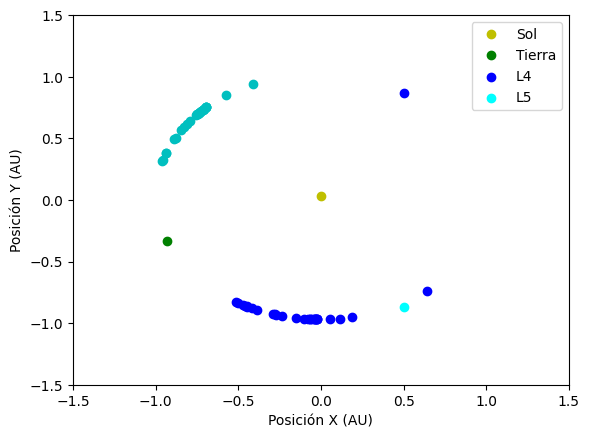

In [ ]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from base64 import b64encode

# Crear la simulación en Rebound
sim = rebound.Simulation()
sim.units = ('AU', 'yr', 'Msun')  # Unidades: UA, años, masas solares
sim.G = 1  # Constante gravitacional

# Parámetros
m_sun = 1.0  # Masa del Sol
m_earth = 3.003e-6  # Masa de la Tierra
a_earth = 1.0  # Distancia media de la Tierra al Sol (1 AU)
v_earth = np.sqrt(sim.G * m_sun / a_earth)  # Velocidad orbital de la Tierra alrededor del Sol (v=sqrt(GM/r))

# Añadir el Sol en reposo
sim.add(m=m_sun, x=0, y=0, vx=0, vy=0)  # Sol fijo en el origen

# Añadir la Tierra con velocidad inicial
sim.add(m=m_earth, x=a_earth, y=0, vx=0, vy=v_earth)  # Tierra orbitando al Sol

# Añadir partículas alrededor de L4 y L5
num_particles = 30  # Número de partículas adicionales por punto
spread = 0.03  # Variación alrededor de la posición de L4 y L5

# Posición relativa de L4 y L5 respecto a la Tierra en un triángulo equilátero
x_L4 = 0.5 * a_earth
y_L4 = np.sqrt(0.75) * a_earth

x_L5 = 0.5 * a_earth
y_L5 = -np.sqrt(0.75) * a_earth

# Velocidades de L4 y L5 (son las mismas, pero con diferentes direcciones)
v_L4_x = -np.sqrt(0.75) * v_earth
v_L4_y = 0.5 * v_earth

v_L5_x = np.sqrt(0.75) * v_earth
v_L5_y = 0.5 * v_earth

# Añadir partículas en torno a L4
for i in range(num_particles):
    delta_x = spread * np.random.uniform(-0.025, 0)
    delta_y = spread * np.random.uniform(-0.025, 0)

    sim.add(m=0, x=x_L4 + delta_x, y=y_L4 + delta_y, vx=v_L4_x, vy=v_L4_y)

# Añadir partículas en torno a L5
for i in range(num_particles):
    delta_x = spread * np.random.uniform(0.025, 0)
    delta_y = spread * np.random.uniform(-0.025, 0)

    sim.add(m=0, x=x_L5 + delta_x, y=y_L5 + delta_y, vx=v_L5_x, vy=v_L5_y)

# Integrar la simulación en el tiempo
times = np.linspace(0, 100, 500)  # Simulación por 100 años en 500 pasos
x_traj_L4, y_traj_L4 = [[] for _ in range(num_particles)], [[] for _ in range(num_particles)]
x_traj_L5, y_traj_L5 = [[] for _ in range(num_particles)], [[] for _ in range(num_particles)]
sun_x, sun_y = [], []
earth_x, earth_y = [], []

for time in times:
    sim.integrate(time)
    for i in range(num_particles):
        # Registrar la posición de cada partícula en L4
        x_traj_L4[i].append(sim.particles[2 + i].x)
        y_traj_L4[i].append(sim.particles[2 + i].y)
        # Registrar la posición de cada partícula en L5
        x_traj_L5[i].append(sim.particles[2 + num_particles + i].x)
        y_traj_L5[i].append(sim.particles[2 + num_particles + i].y)

    # Registrar la posición del Sol y la Tierra
    sun_x.append(sim.particles[0].x)
    sun_y.append(sim.particles[0].y)
    earth_x.append(sim.particles[1].x)
    earth_y.append(sim.particles[1].y)

# Graficar la simulación
fig, ax = plt.subplots()
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel("Posición X (AU)")
ax.set_ylabel("Posición Y (AU)")

# Graficar el Sol, la Tierra y los puntos iniciales de L4 y L5
sol, = ax.plot([], [], 'yo', label='Sol')
tierra, = ax.plot([], [], 'go', label='Tierra')
ax.scatter([x_L4], [y_L4], color='blue', label='L4')
ax.scatter([x_L5], [y_L5], color='cyan', label='L5')
ax.legend()
# Inicializar los puntos que se van a mover (L4 y L5)
points_L4 = [ax.plot([], [], 'bo')[0] for _ in range(num_particles)]
points_L5 = [ax.plot([], [], 'co')[0] for _ in range(num_particles)]

# Inicialización de la animación
def init():
    for point in points_L4 + points_L5:
        point.set_data([], [])
    sol.set_data([], [])
    tierra.set_data([], [])
    return points_L4 + points_L5 + [sol, tierra]

# Función de actualización de la animación
def update(frame):
    for i, point in enumerate(points_L4):
        point.set_data(x_traj_L4[i][frame], y_traj_L4[i][frame])
    for i, point in enumerate(points_L5):
        point.set_data(x_traj_L5[i][frame], y_traj_L5[i][frame])
    sol.set_data(sun_x[frame], sun_y[frame])
    tierra.set_data(earth_x[frame], earth_y[frame])
    return points_L4 + points_L5 + [sol, tierra]

# Crear la animación
ani = FuncAnimation(fig, update, frames=len(times), init_func=init, blit=True, interval=50)

# Guardar la animación como archivo MP4
ani.save('trayectoria_L4_L5_moviendose_con_tierra.mp4', writer='ffmpeg')

# Mostrar la animación en Colab
mp4 = open('trayectoria_L4_L5_moviendose_con_tierra.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'<video width="600" controls><source src="{data_url}" type="video/mp4"></video>')
